In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!pip install -q keras

In [0]:
from glob import glob
from os import listdir
from sklearn.model_selection import train_test_split

haemorrhage = glob('cs682-gan/train/Haemorrhage/*.jpg')
clear = glob('cs682-gan/train/Clear/*.jpg')
haemorrhage_train, haemorrhage_test = train_test_split(haemorrhage, test_size=0.30)
clear_train, clear_test = train_test_split(clear, test_size=0.30)

TRAIN_DIR = 'cs682-gan/train'
TEST_DIR = 'cs682-gan/test'

# print(clear_test)
!mkdir cs682-gan/test

!mkdir cs682-gan/test/Haemorrhage
files = ' '.join(haemorrhage_test)
!mv -t cs682-gan/test/Haemorrhage $files

!mkdir cs682-gan/test/Clear
files = ' '.join(clear_test)
!mv -t cs682-gan/test/Clear $files

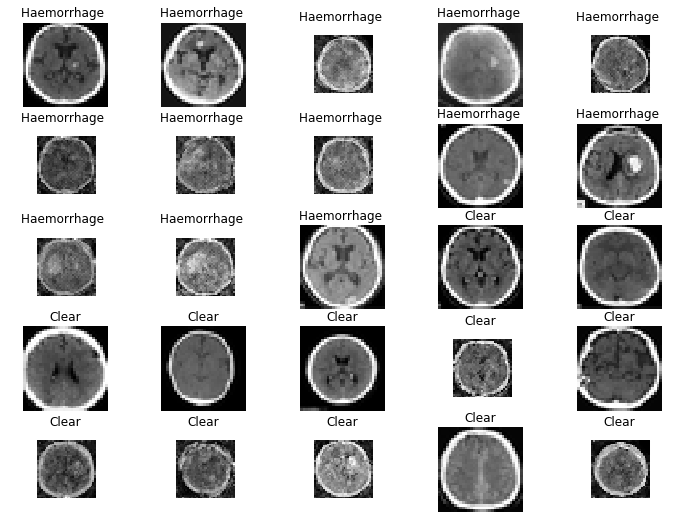

In [44]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

haemorrhage = np.random.choice(haemorrhage_train, 13)
clear = np.random.choice(clear_train, 12)
data = np.concatenate((haemorrhage, clear))
labels = 13 * ['Haemorrhage '] + 12 *['Clear']

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

In [45]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras import backend as K

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
   
CLASSES = 2
    
# setup model
base_model = ResNet50(weights= 'imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [46]:
from keras.preprocessing.image import ImageDataGenerator

WIDTH = 128
HEIGHT = 128
BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 280 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

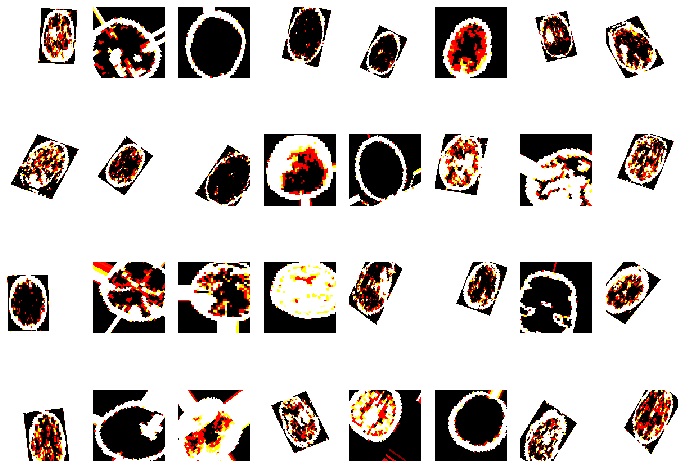

In [47]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [48]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'gan.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/5
320/320 [==============================] - 69s 215ms/step - loss: 0.5716 - acc: 0.7277 - val_loss: 1.0437 - val_acc: 0.6245
Epoch 2/5
320/320 [==============================] - 58s 180ms/step - loss: 0.4649 - acc: 0.7879 - val_loss: 0.8061 - val_acc: 0.6865
Epoch 3/5
320/320 [==============================] - 56s 176ms/step - loss: 0.4482 - acc: 0.8029 - val_loss: 1.0573 - val_acc: 0.6359
Epoch 4/5
320/320 [==============================] - 58s 183ms/step - loss: 0.4292 - acc: 0.8083 - val_loss: 1.3332 - val_acc: 0.6109
Epoch 5/5
320/320 [==============================] - 57s 178ms/step - loss: 0.4394 - acc: 0.8061 - val_loss: 0.9817 - val_acc: 0.6651


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("clear ", "haemorrhage ")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [0]:
model = load_model(MODEL_FILE)

array([0.97391933, 0.02608062], dtype=float32)

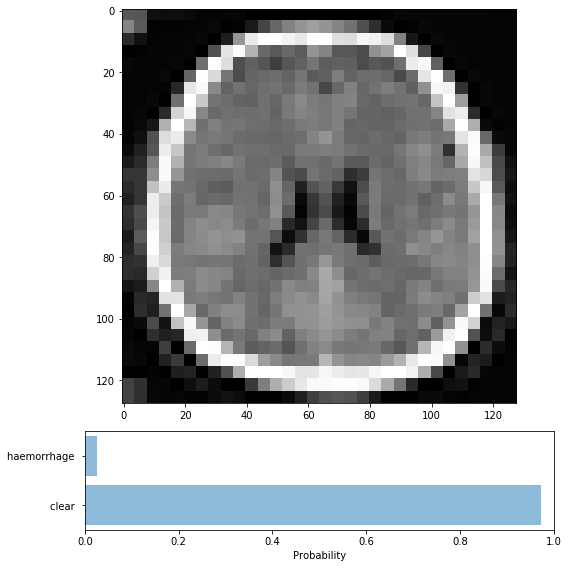

In [55]:
img = image.load_img('cs682-gan/test/Clear/122.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
____________________________________________________________________________________________